In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os, jdc, shutil
from tqdm import tqdm

from rl_glue import RLGlue
from agent import BaseAgent
from maze_env import MazeEnvironment2
import seaborn as sns

In [6]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [8,5]})

## Disclaimer
This notebook uses code from the Alberta RL MOOC from Adam and Martha White

## TD agent 

In [7]:
# Create empty TDAgent class.
# These methods will be filled in later cells.

class TDAgent(BaseAgent):
    def agent_init(self, agent_info={}):
        raise NotImplementedError
        
    def agent_start(self, state):
        raise NotImplementedError

    def agent_step(self, reward, state):
        raise NotImplementedError

    def agent_end(self, reward):
        raise NotImplementedError

    def agent_cleanup(self):        
        raise NotImplementedError
        
    def agent_message(self, message):
        raise NotImplementedError

In [8]:
%%add_to TDAgent

def agent_init(self, agent_info={}):
    """Setup for the agent called when the experiment first starts."""

    # Create a random number generator with the provided seed to seed the agent for reproducibility.
    self.rand_generator = np.random.RandomState(agent_info.get("seed"))

    # Policy will be given, recall that the goal is to accurately estimate its corresponding value function. 
    self.policy = agent_info.get("policy")
    # Discount factor (gamma) to use in the updates.
    self.discount = agent_info.get("discount")
    # The learning rate or step size parameter (alpha) to use in updates.
    self.step_size = agent_info.get("step_size")

    # Initialize an array of zeros that will hold the values.
    # Recall that the policy can be represented as a (# States, # Actions) array. With the 
    # assumption that this is the case, we can use the first dimension of the policy to
    # initialize the array for values.
    self.values = np.zeros((self.policy.shape[0],))
    self.obstacles = [[2,1],[3,1],[4,1],[0,4],[1,4],[5,5],[1,7],[2,7],[2,8],[3,8]]
    for (i,j) in self.obstacles:
        state = i*10 + j
        self.values[state] = np.NAN

In [9]:
%%add_to TDAgent

def agent_start(self, state):
    """The first method called when the episode starts, called after
    the environment starts.
    Args:
        state (Numpy array): the state from the environment's env_start function.
    Returns:
        The first action the agent takes.
    """
    # The policy can be represented as a (# States, # Actions) array. So, we can use 
    # the second dimension here when choosing an action.
    action = self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])
    self.last_state = state
    return action

In [10]:
%%add_to TDAgent

def agent_step(self, reward, state):
    """A step taken by the agent.
    Args:
        reward (float): the reward received for taking the last action taken
        state (Numpy array): the state from the
            environment's step after the last action, i.e., where the agent ended up after the
            last action
    Returns:
        The action the agent is taking.
    """
    ### START CODE HERE ###
    # Hint: We should perform an update with the last state given that we now have the reward and
    # next state. We break this into two steps. Recall for example that the Monte-Carlo update 
    # had the form: V[S_t] = V[S_t] + alpha * (target - V[S_t]), where the target was the return, G_t.
    target = reward + self.discount * self.values[state]
    self.values[self.last_state] += self.step_size * (target - self.values[self.last_state])
    ### END CODE HERE ###

    # Having updated the value for the last state, we now act based on the current 
    # state, and set the last state to be current one as we will next be making an 
    # update with it when agent_step is called next once the action we return from this function 
    # is executed in the environment.

    action = self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])
    self.last_state = state

    return action

In [11]:
%%add_to TDAgent

def agent_end(self, reward):
    """Run when the agent terminates.
    Args:
        reward (float): the reward the agent received for entering the terminal state.
    """
    ### START CODE HERE ###
    # Hint: Here too, we should perform an update with the last state given that we now have the 
    # reward. Note that in this case, the action led to termination. Once more, we break this into 
    # two steps, computing the target and the update itself that uses the target and the 
    # current value estimate for the state whose value we are updating.
    target = reward
    self.values[self.last_state] += self.step_size * (target - self.values[self.last_state])
    ### END CODE HERE ###

In [12]:
%%add_to TDAgent

def agent_cleanup(self):
    """Cleanup done after the agent ends."""
    self.last_state = None

In [13]:
%%add_to TDAgent

# Do not modify this cell!

# Work Required: No.
def agent_message(self, message):
    """A function used to pass information from the agent to the experiment.
    Args:
        message: The message passed to the agent.
    Returns:
        The response (or answer) to the message.
    """
    if message == "get_values":
        return self.values
    else:
        raise Exception("TDAgent.agent_message(): Message not understood!")

In [14]:
%matplotlib notebook

def run_experiment(agent_info, 
                   num_episodes=5000,
                   plot_freq=100,
                   value_error_threshold=1e-8):
    env = MazeEnvironment2
    agent = TDAgent
    rl_glue = RLGlue(env, agent)

    rl_glue.rl_init(agent_info)

    for episode in range(1, num_episodes + 1):
        rl_glue.rl_episode(0) # no step limit
        if episode % plot_freq == 0:
            values = rl_glue.agent.agent_message("get_values")

    values = rl_glue.agent.agent_message("get_values")
    
    return values

In [15]:
# Experiment parameters
# Agent parameters
agent_parameters = {
    "discount": 0.95, 
    "step_size" : 0.1
}

# Random policy that strides just along the cliff
policy = np.ones(shape=(6 * 10, 4)) * 0.25
agent_parameters.update({"policy": policy})

In [16]:
values = run_experiment(agent_parameters, num_episodes=100)

<IPython.core.display.Javascript object>


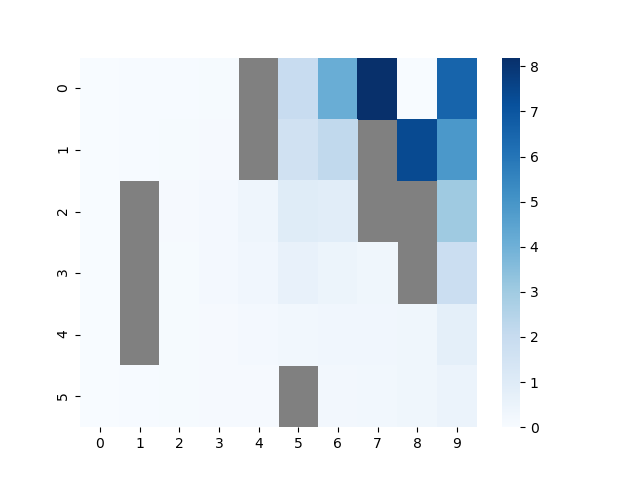

In [17]:
h = sns.heatmap((values.reshape((6,10))), cmap="Blues")
h.set_facecolor('grey')
plt.show()
plt.savefig('results/TDAgent.png')

In [16]:
np.savetxt("results/TDAgent_values.txt", values)

## TD with linear approximation 

In [18]:
import tiles3 as tc

In [19]:
class MazeTileCoder:
    def __init__(self, iht_size=4096, num_tilings=4, num_tiles=4):
        """
        Initializes the Maze Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the
                     tile coder are the same
        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """
        self.iht = tc.IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
    
    def get_tiles(self, position_i, position_j):
        """
        Takes in a position and velocity from the mountaincar environment
        and returns a numpy array of active tiles.
        
        Arguments:
        position -- integer, the position of the agent between 0 and 9
        returns:
        tiles - np.array, active tiles
        """
        POSITION_MIN_i = 0
        POSITION_MAX_i = 5
        POSITION_MIN_j = 0
        POSITION_MAX_j = 9

        tiles = tc.tiles(self.iht, self.num_tilings, [(5-position_i), 
                                                      position_j])  
        return np.array(tiles)

In [20]:
# Create LinearTDAgent
class LinearTDAgent(BaseAgent):
        
    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts."""
    
        # Create a random number generator with the provided seed to seed the agent for reproducibility.
        self.rand_generator = np.random.RandomState(agent_info.get("seed"))
        # Policy will be given, recall that the goal is to accurately estimate its corresponding value function. 
        self.policy = agent_info.get("policy")
        # Discount factor (gamma) to use in the updates.
        self.discount = agent_info.get("discount")
        # The learning rate or step size parameter (alpha) to use in updates.
        self.step_size = agent_info.get("step_size")
        
        # tiles
        self.num_tilings = agent_info.get("num_tilings", 4)
        self.num_tiles = agent_info.get("num_tiles", 4)
        self.iht_size = agent_info.get("iht_size", 4096)
        
        # we have two features
        self.weights = np.ones(self.iht_size,) * 0
        # values
        self.values = np.empty((6,10))
        self.values[:] = np.NAN
        self.values[0,8] = 0
        # tile coder
        self.tc = MazeTileCoder(iht_size=self.iht_size, 
                                         num_tilings=self.num_tilings, 
                                         num_tiles=self.num_tiles)

        # stores all possible features
        # self.all_state_features = np.array([[i/6, j/10] for i in range(6) for j in range(10)])


        self.last_state = None
        self.last_action = None

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            self.last_action [int] : The first action the agent takes.
        """

        ### select action given state (using agent_policy), and save current state and action (2~3 lines)
        # Use self.rand_generator for agent_policy
        # 
        # self.last_state = ?
        # self.last_action = ?

        ### START CODE HERE ###
        self.last_state = state
        self.last_action = self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])

        ### END CODE HERE ###

        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward [float]: the reward received for taking the last action taken
            state [int]: the state from the environment's step, where the agent ended up after the last step
        Returns:
            self.last_action [int] : The action the agent is taking.
        """
        
        # get relevant feature
        current_i = state//10
        current_j = state%10
        
        last_i = self.last_state//10
        last_j = self.last_state%10
        
        active_tiles = self.tc.get_tiles(current_i, current_j)
        last_tiles = self.tc.get_tiles(last_i, last_j)
        
        
        ### update weights and select action (3~5 lines)
        # (Hint: np.dot method is useful!)
        #
        # Update weights:
        #     use self.weights, current_state_feature, and last_state_feature
        #
        # Select action:
        #     use self.rand_generator for agent_policy
        #
        # Current state and selected action should be saved to self.last_state and self.last_action at the end
        #
        # self.weights = ?
        # self.last_state = ?
        # self.last_action = ?

        ### START CODE HERE ###
        self.weights[last_tiles] += self.step_size*(reward + np.sum(self.weights[active_tiles])*self.discount - np.sum(self.weights[last_tiles]))
        self.values[last_i, last_j] = np.sum(self.weights[last_tiles])
        self.last_state = state
        self.last_action = self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])
        ### END CODE HERE ###
        return self.last_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """

        # get relevant feature
        last_i = self.last_state//10
        last_j = self.last_state%10
        last_tiles = self.tc.get_tiles(last_i, last_j)
        
        ### update weights (1~2 lines)
        # Update weights using self.weights and last_state_feature
        # (Hint: np.dot method is useful!)
        # 
        # Note that here you don't need to choose action since the agent has reached a terminal state
        # Therefore you should not update self.last_state and self.last_action
        # 
        # self.weights = ?
        
        ### START CODE HERE ###
        self.weights[last_tiles] += self.step_size*(reward - np.sum(self.weights[last_tiles]))
        self.values[last_i, last_j] = np.sum(self.weights[last_tiles])
        ### END CODE HERE ###
        return
        
    def agent_message(self, message):
        # We will implement this method later
        raise NotImplementedError


In [21]:
%%add_to LinearTDAgent
def agent_message(self, message):
    if message == 'get_values':
        return self.values

In [26]:
%matplotlib notebook

def run_experiment2(agent_info, 
                   num_episodes=5000,
                   plot_freq=100,
                   value_error_threshold=1e-8):
    env = MazeEnvironment2
    agent = LinearTDAgent
    rl_glue = RLGlue(env, agent)

    rl_glue.rl_init(agent_info)

    for episode in range(1, num_episodes + 1):
        rl_glue.rl_episode(0) # no step limit
        if episode % plot_freq == 0:
            values = rl_glue.agent.agent_message("get_values")

    values = rl_glue.agent.agent_message("get_values")
    
    return rl_glue, values

In [48]:
# Experiment parameters
# Agent parameters
agent_parameters = {
    "discount": 0.95, 
    "step_size" : 0.1/4,
    "num_tilings": 1,
    "num_tiles": 1
}

# Random policy that strides just along the cliff
policy = np.ones(shape=(6 * 10, 4)) * 0.25
agent_parameters.update({"policy": policy})

In [49]:
rl, values = run_experiment2(agent_parameters, num_episodes=100)

<IPython.core.display.Javascript object>


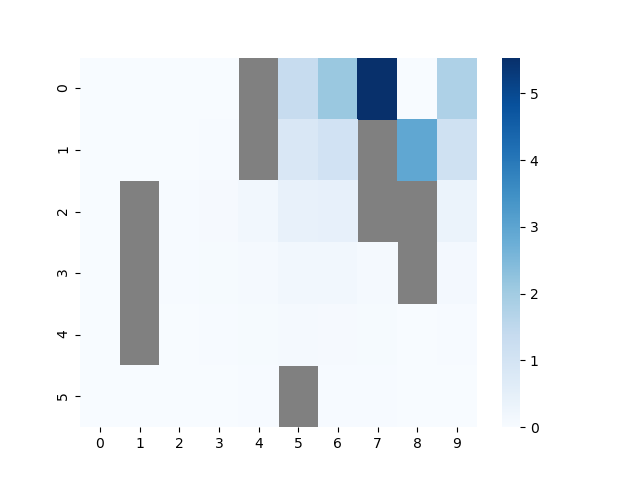

In [50]:
h = sns.heatmap(values, cmap = "Blues")
h.set_facecolor('grey')
plt.show()
plt.savefig('results/tileLinearTDAgent.png')

In [25]:
np.savetxt('results/tileLinearTDAgent.txt', values)

In [350]:
## tile coding generalises better across states and converges faster

In [51]:
len(np.where(rl.agent.weights != 0)[0])

49

In [43]:
196/4

49.0

In [65]:
def minimumBribes(q):
    min_bribes = 0
    for j in range(len(q)):
        diff = q[j] - (j+1)
        if diff > 2:
            return("Too chaotic")
            break
        elif diff >= 0:
            min_bribes += diff
    return(min_bribes)

In [66]:
minimumBribes([2,5,1,3,4])

'Too chaotic'

In [132]:
def minimumSwaps(arr):
    count = 0
    i = 0
    while i <= len(arr) - 2:
        k = i
        j = i+1
        print(k)
        print(j)
        print("\n")
        swap = False
        while (arr[k] > arr[j])&(k >= 0):
            swap = True
            k = k-1
        if swap:
            print("swap")
            print(arr[k+1], arr[j])
            count+=1
            arr[k+1], arr[j] = arr[j], arr[k+1]
        elif not swap:
            i = i+1
    print(count)
    print(arr)

In [133]:
arr = [4,3,1,2]

In [149]:
def maxSubsetSum(arr):
    n = len(arr)
    if n == 0:
        return(0)
    elif n == 1:
        return arr[0]
    elif n == 2:
        return max(arr[0], arr[1])
    elif n == 3:
        return max(max([arr[0], arr[2], arr[0] + arr[2]]) , arr[1])
    else:
        l1 = arr[2:]
        l2 = arr[3:]
        print(l1)
        print(l2)
        S1 = maxSubsetSum(l1)
        S2 = maxSubsetSum(l2)
        return max([S1 + arr[0], S2 + arr[1]])
    

In [150]:
arr = [2, 1, 5, 8, 4]

In [151]:
maxSubsetSum(arr)

[5, 8, 4]
[8, 4]


11

In [152]:
arr = [5, 8, 4]

In [153]:
maxSubsetSum(arr)

9

In [158]:
for j in range(10-1, -1, -1):
    print(j)

9
8
7
6
5
4
3
2
1
0


In [165]:
cost = [5,6,3]
for i, c in enumerate(cost):
    print(c)

5
6
3
